In [33]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import statsmodels.api as sm

In [34]:
# Read data
df = pd.read_csv("./All Data.csv")
# Replace NaN percents with 0%
df = df.fillna('0%')

# Remove Team, Win, Loss columns
data = df.drop(['GP', 'Team', 'W', 'L', 'division', 'GPR'], axis = 1)
data.describe()

,AGT,K,D,KD,CKPM,GSPD,GD15,FB%,FT%,F3T%,...,BN%,LNE%,JNG%,WPM,CWPM,WCPM,win_rate,year,EGR,MLR
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,...,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,34.390476,125.087719,125.428571,1.012005,0.746416,-0.012301,-135.273183,0.444862,0.435890,0.425915,...,0.440426,0.447987,0.453461,3.219173,0.975764,1.288195,44.597018,20.179499,32.896491,-2.355388
std,3.457307,92.600155,84.898990,0.536490,0.146694,0.075798,1237.030261,0.245878,0.241694,0.259136,...,0.233307,0.152075,0.141766,1.076066,0.439101,0.473416,25.363616,0.020685,24.840955,15.627106
min,24.500000,5.000000,8.000000,0.170000,0.330000,-0.326000,-5932.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.150000,0.000000,-56.300000
25%,32.050000,54.000000,66.000000,0.720000,0.650000,-0.049000,-744.500000,0.310000,0.305000,0.250000,...,0.290000,0.490500,0.460500,3.075000,0.695000,1.140000,26.390000,20.160000,0.000000,-8.950000
50%,34.300000,104.000000,95.000000,0.950000,0.740000,0.000000,0.000000,0.500000,0.460000,0.450000,...,0.460000,0.498000,0.492000,3.440000,1.100000,1.390000,42.860000,20.180000,41.100000,0.000000
75%,36.400000,176.500000,161.500000,1.220000,0.850000,0.028500,558.000000,0.610000,0.610000,0.610000,...,0.600000,0.505000,0.517000,3.770000,1.300000,1.575000,60.555000,20.190000,53.200000,1.200000
max,48.500000,477.000000,460.000000,7.000000,1.130000,0.269000,3129.000000,1.000000,1.000000,1.000000,...,1.000000,0.521000,0.613000,5.410000,1.780000,2.140000,100.000000,20.210000,82.300000,53.400000


<AxesSubplot:xlabel='GD15', ylabel='win_rate'>

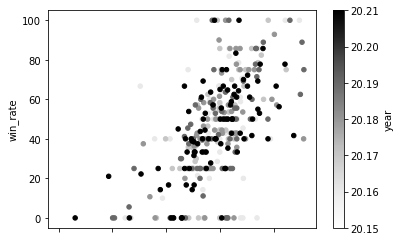

In [35]:
data.plot.scatter(x='GD15', y='win_rate', c = 'year')

In [37]:
# Convert W%
# 1 for >= 40% W%, 0 for < 40%

# Get unique winrates
wins = list(set(data.get('win_rate'))) 
# Extract winrates lower and higher than 40%
low = tuple([i for i in wins if i < 0.4])
high = tuple([i for i in wins if i >= 0.4])

# Replace winrates with binary 0/1
data.replace({low: 0, high: 1}, inplace = True)
data.head()

,AGT,K,D,KD,CKPM,GSPD,GD15,FB%,FT%,F3T%,...,BN%,LNE%,JNG%,WPM,CWPM,WCPM,win_rate,year,EGR,MLR
0,42.7,239,235,1.02,0.85,0.000,0.0,0.00,0.00,0.00,...,0.40,0.000,0.000,0.00,0.00,0.00,1.0,20.15,0.0,0.0
1,35.8,214,269,0.80,0.96,-0.062,-1303.0,0.50,0.36,0.29,...,0.53,0.495,0.446,2.21,0.32,0.69,1.0,20.15,0.0,0.0
2,39.3,80,121,0.66,0.85,0.000,0.0,0.00,0.00,0.00,...,0.00,0.000,0.000,0.00,0.00,0.00,1.0,20.15,0.0,0.0
3,33.9,291,175,1.66,0.98,0.153,867.0,0.43,0.79,0.86,...,0.88,0.520,0.506,2.37,0.34,0.82,1.0,20.15,0.0,0.0
4,27.6,27,110,0.25,0.99,-0.326,-5932.0,0.20,0.00,0.00,...,0.00,0.457,0.387,2.82,0.27,0.60,0.0,20.15,0.0,0.0


In [38]:
# SKLearn Logistic Regression process derived from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# Get features and remove target
features = list(data.columns)
features.remove('win_rate') 

# Separating out the features
X = pd.DataFrame(data.loc[:, features])
# Separating out the target
y = pd.DataFrame(data.loc[:,['win_rate']])

# Split data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [39]:
# Instantiate the model
logMod = LogisticRegression(max_iter = 1000)

# Fit the model
logMod.fit(X_train, y_train.to_numpy().ravel())

# Get prediction
yPred = logMod.predict(X_test)

In [40]:
cnf_matrix = metrics.confusion_matrix(y_test, yPred)
cnf_matrix

array([[12,  2],
       [ 0, 86]], dtype=int64)

In [41]:
print("Accuracy:",metrics.accuracy_score(y_test, yPred))
print("Precision:",metrics.precision_score(y_test, yPred))
print("Recall:",metrics.recall_score(y_test, yPred))

Accuracy: 0.98
Precision: 0.9772727272727273
Recall: 1.0


In [42]:
rfe = RFE(logMod)
rfe = rfe.fit(X, y.values.ravel())

print(rfe.support_)
print(rfe.ranking_)

[False False False False False  True False  True  True  True  True  True
  True  True  True False False False  True  True  True False False False]
[10  5  6  7  4  1 13  1  1  1  1  1  1  1  1  9  8 11  1  1  1 12  3  2]


In [43]:
X = X.loc[:, rfe.support_]
logit_model=sm.Logit(y,X)
result=logit_model.fit(method = 'bfgs')
print(result.summary2())

         Current function value: 0.198609
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.460     
Dependent Variable: win_rate         AIC:              182.4900  
Date:               2022-04-29 18:26 BIC:              230.3576  
No. Observations:   399              Log-Likelihood:   -79.245   
Df Model:           11               LL-Null:          -146.64   
Df Residuals:       387              LLR p-value:      1.8596e-23
Converged:          0.0000           Scale:            1.0000    
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
GSPD       3.5420     3.5292    1.0036   0.3156   -3.3751   10.4591
FB%        0.2262     1.0127    0.2233   0.8233   -1.7588    2.2111
FT%        0.9362     1.

C:\Users\kilbo\anaconda3\envs\py3.8\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
